In [36]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_video
from torchvision import transforms
from PIL import Image

class UCF11_LSTM_Dataset(Dataset):
    def __init__(self, root_dir, num_frames=10, transform=None):
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.video_paths = []

        for cls in self.classes:
            class_path = os.path.join(root_dir, cls)
            for subfolder in os.listdir(class_path):
                subfolder_path = os.path.join(class_path, subfolder)
                if os.path.isdir(subfolder_path):
                    for file in os.listdir(subfolder_path):
                        if file.endswith((".mp4", ".mpg")):
                            self.video_paths.append((
                                os.path.join(subfolder_path, file),
                                self.class_to_idx[cls]
                            ))

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        path, label = self.video_paths[idx]

        try:
            frames, _, _ = read_video(path, pts_unit='sec')
        except Exception as e:
            print(f"?? Failed to load video: {path} | {e}")
            return self.__getitem__((idx + 1) % len(self.video_paths))

        if frames.ndim != 4 or frames.shape[-1] != 3 or len(frames) == 0:
            print(f"? Skipping malformed video: {path} | shape: {frames.shape}")
            return self.__getitem__((idx + 1) % len(self.video_paths))

        T = frames.shape[0]

        if T >= self.num_frames:
            indices = np.linspace(0, T - 1, self.num_frames).astype(int)
            sampled = frames[indices]
        else:
            padding = self.num_frames - T
            sampled = torch.cat([frames, frames[-1:].repeat(padding, 1, 1, 1)], dim=0)

        transformed_frames = []
        for i in range(self.num_frames):
            frame = sampled[i].numpy().astype(np.uint8)
            img = Image.fromarray(frame)
            img = self.transform(img)
            transformed_frames.append(img)

        clip = torch.stack(transformed_frames)  
        return clip, label


In [37]:
import os
import shutil
from glob import glob

src_root = os.path.expanduser("~/notebooks/UCF11_updated_mpg")
dst_root = os.path.expanduser("~/notebooks/split_ucf11/test")

os.makedirs(dst_root, exist_ok=True)

for cls in os.listdir(src_root):
    cls_path = os.path.join(src_root, cls)
    if not os.path.isdir(cls_path) or cls == "Annotation":
        continue

    dst_cls = os.path.join(dst_root, cls)
    os.makedirs(dst_cls, exist_ok=True)

    for folder in os.listdir(cls_path):
        if any(folder.endswith(f"_{i:02}") for i in range(20, 26)):
            full_path = os.path.join(cls_path, folder)
            shutil.copytree(full_path, os.path.join(dst_cls, folder), dirs_exist_ok=True)

print(" Test set created from folders 20?25.")


 Test set created from folders 20?25.


In [38]:
train_dataset = UCF11_LSTM_Dataset(os.path.expanduser("~/notebooks/split_ucf11/train"))
val_dataset   = UCF11_LSTM_Dataset(os.path.expanduser("~/notebooks/split_ucf11/val"))
test_dataset  = UCF11_LSTM_Dataset(os.path.expanduser("~/notebooks/split_ucf11/test"))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [39]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [40]:
dataset = UCF11_LSTM_Dataset(os.path.expanduser("~/notebooks/split_ucf11/train"))
print("Dataset length:", len(dataset))

clip, label = dataset[0]
print("Clip shape:", clip.shape)  # Should be: torch.Size([10, 3, 224, 224])
print("Label:", label)


Dataset length: 1257
Clip shape: torch.Size([10, 3, 224, 224])
Label: 0


In [41]:
import torchvision.models as models
import torch.nn as nn
import torch

class ResNetEncoder(nn.Module):
    def __init__(self, embedding_dim=512, freeze=True):
        super(ResNetEncoder, self).__init__()
        base = models.resnet18(pretrained=True)
        modules = list(base.children())[:-1]  
        self.encoder = nn.Sequential(*modules)
        self.embedding_dim = embedding_dim

        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False

    def forward(self, x):  # x: (B * T, 3, 224, 224)
        x = self.encoder(x)  # (B * T, 512, 1, 1)
        x = x.view(x.size(0), -1)  # (B * T, 512)
        return x


In [42]:
class ResNetLSTMClassifier(nn.Module):
    def __init__(self, embedding_dim=512, hidden_dim=256, num_layers=1, num_classes=11):
        super(ResNetLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, embeddings):  # (B, T, 512)
        lstm_out, _ = self.lstm(embeddings)  # (B, T, hidden_dim)
        final_output = lstm_out[:, -1, :]    # Use last hidden state
        logits = self.fc(final_output)       # (B, num_classes)
        return logits


In [43]:
resnet_encoder = ResNetEncoder(embedding_dim=512, freeze=True).to(device)
lstm_classifier = ResNetLSTMClassifier().to(device)


/home/exouser/.conda/envs/my5920_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/.conda/envs/my5920_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(lstm_classifier.parameters())  # only train LSTM
optimizer = optim.Adam(params, lr=3e-4)

epochs = 5

for epoch in range(epochs):
    resnet_encoder.eval()  # Encoder frozen
    lstm_classifier.train()

    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for clips, labels in pbar:
        # clips: [B, T, 3, 224, 224]
        B, T, C, H, W = clips.shape

        clips = clips.view(B * T, C, H, W).to(device)
        labels = labels.to(device)

        with torch.no_grad():
            embeddings = resnet_encoder(clips)  # [B*T, 512]

        embeddings = embeddings.view(B, T, -1)  # [B, T, 512]

        outputs = lstm_classifier(embeddings)  # [B, num_classes]
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss=loss.item(), acc=100. * correct / total)

    acc = 100. * correct / total
    print(f"\n Epoch {epoch+1} completed | Loss: {running_loss:.4f} | Accuracy: {acc:.2f}%\n")


Epoch 1/5: 100%|██████████| 315/315 [01:55<00:00,  2.73it/s, acc=63.2, loss=1.98] 



 Epoch 1 completed | Loss: 389.4913 | Accuracy: 63.25%



Epoch 2/5: 100%|██████████| 315/315 [01:41<00:00,  3.11it/s, acc=85.7, loss=0.0163]



 Epoch 2 completed | Loss: 158.5953 | Accuracy: 85.68%



Epoch 3/5: 100%|██████████| 315/315 [01:47<00:00,  2.94it/s, acc=91.9, loss=0.0369]



 Epoch 3 completed | Loss: 95.9280 | Accuracy: 91.89%



Epoch 4/5: 100%|██████████| 315/315 [01:57<00:00,  2.68it/s, acc=95.6, loss=0.00158]



 Epoch 4 completed | Loss: 55.5010 | Accuracy: 95.62%



Epoch 5/5: 100%|██████████| 315/315 [01:57<00:00,  2.68it/s, acc=96.1, loss=0.00444]


 Epoch 5 completed | Loss: 55.4648 | Accuracy: 96.10%



In [45]:
# Save the model's state dict
torch.save({
    'epoch': epoch,
    'model_state_dict': lstm_classifier.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': running_loss,
}, 'lstm_resnet_model.pth')

print(" Model saved successfully!")


 Model saved successfully!


In [46]:

lstm_classifier.eval()  # Set the model to evaluation mode

test_correct = 0
test_total = 0
test_loss = 0.0

with torch.no_grad():
    for clips, labels in test_loader:
        clips = clips.to(device)
        labels = labels.to(device)

        # Reshape to [B * T, C, H, W] before passing through ResNet
        B, T, C, H, W = clips.shape
        clips = clips.view(B * T, C, H, W)

        
        embeddings = resnet_encoder(clips)
        embeddings = embeddings.view(B, T, -1)

        outputs = lstm_classifier(embeddings)

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = outputs.max(1)
        test_correct += predicted.eq(labels).sum().item()
        test_total += labels.size(0)

test_acc = 100. * test_correct / test_total
test_loss_avg = test_loss / len(test_loader)

print(f" Test Accuracy: {test_acc:.2f}%")
print(f" Test Loss: {test_loss_avg:.4f}")


 Test Accuracy: 83.29%
 Test Loss: 0.5237


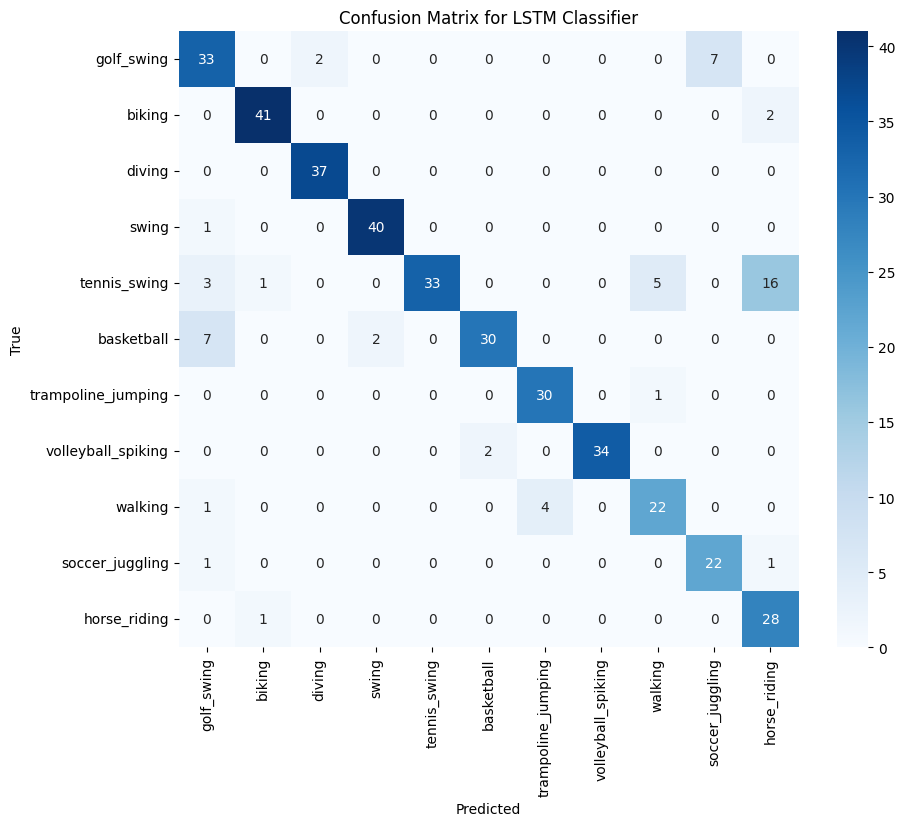

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ['golf_swing', 'biking', 'diving', 'swing', 'tennis_swing', 
               'basketball', 'trampoline_jumping', 'volleyball_spiking', 
               'walking', 'soccer_juggling', 'horse_riding']

all_preds = []
all_labels = []

lstm_classifier.eval()  
with torch.no_grad():
    for clips, labels in test_loader:
        clips = clips.to(device)
        labels = labels.to(device)

        B, T, C, H, W = clips.shape
        clips = clips.view(B * T, C, H, W)

        embeddings = resnet_encoder(clips)

        embeddings = embeddings.view(B, T, -1)

        outputs = lstm_classifier(embeddings)

        _, predicted = outputs.max(1)  # Fixed the missing parenthesis

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LSTM Classifier')
plt.show()
